In [2]:
import numpy as np
import matplotlib as mp
import ccdproc,os,sys,time,random
from glob import glob
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.time import Time
from astropy.wcs import WCS
import astroalign as aa
from astropy.nddata import CCDData
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.visualization import ImageNormalize, LogStretch
from matplotlib.ticker import LogLocator
from astropy.stats import SigmaClip, mad_std
from photutils.background import Background2D, MeanBackground,SExtractorBackground, MedianBackground
from photutils import find_peaks, CircularAperture, CircularAnnulus, aperture_photometry,DAOStarFinder,IRAFStarFinder
from photutils.centroids import centroid_2dg
from photutils.utils import calc_total_error
from astropy.io import ascii

In [3]:
filepath='/home/abhishek/ATSOA/atsoa_2022/sa101_standard/'
os.chdir(filepath)

In [4]:
ast_cln_list=sorted(glob('SA101_*ast.fits'))
ast_cln_list

['SA101_150_V_01_cln_ast.fits',
 'SA101_150_V_02_cln_ast.fits',
 'SA101_150_V_03_cln_ast.fits',
 'SA101_150_V_04_cln_ast.fits']

In [5]:
hdu=fits.open('SA101_150_V_01_cln_ast.fits')[0] #file name
header=hdu.header
image=hdu.data

In [6]:
mean,median,std=sigma_clipped_stats(image)

In [7]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(image, (100, 100), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

In [8]:
back=bkg.background # this is the background we need for the background subtraction.
back2,std2=np.median(bkg.background),np.std(bkg.background),
print('median background is',back2)
print('standard deviation of background is',std2)

median background is 179.7324091438336
standard deviation of background is 1.0149520566913313


Text(0.5, 1.0, 'SA101_150_V_01_cln_ast background')

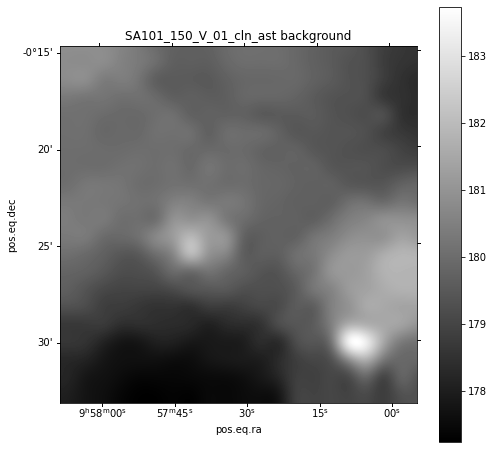

In [9]:
plt.figure(figsize=(8,8))
plt.subplot(111,projection=WCS(header))
plt.imshow(back,aspect='equal',cmap='gray')
plt.colorbar()
plt.title('SA101_150_V_01_cln_ast background')
#plt.savefig('/home/abhishek/ATSOA/Photometry project/Project PPT/Background_2D.png',facecolor='white',edgecolor='white')

In [10]:
print('Finding the sources')
iraffind=IRAFStarFinder(fwhm=3,threshold=6*std)
sources=iraffind(image-back)

Finding the sources


In [11]:
print('We have found :',len(sources),' sources')
px,py=sources['xcentroid'], sources['ycentroid']

We have found : 118  sources


In [12]:
FWHM=sources['fwhm']
FWHM_median=np.median(FWHM)
print(FWHM_median)

1.9522572353519387


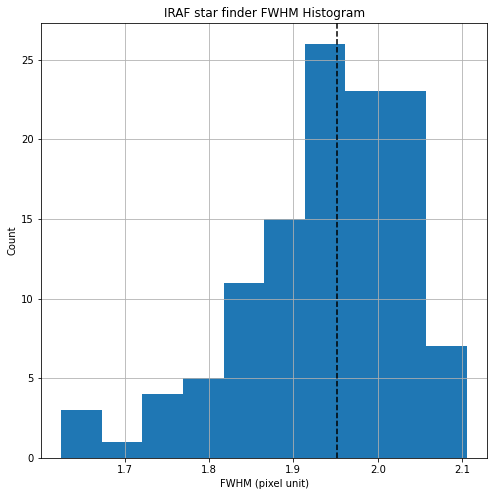

In [13]:
plt.figure(figsize=(8,8))
plt.hist(FWHM)
plt.axvline(x=FWHM_median,color='black',linestyle='--')
plt.ylabel('Count')
plt.xlabel('FWHM (pixel unit)')
plt.title('IRAF star finder FWHM Histogram')
plt.grid()
#plt.savefig('/home/abhishek/ATSOA/Photometry project/Project PPT/FWHM_histogram.png',facecolor='white',edgecolor='white')

In [14]:
radii=[1,2,3,4,5,6,7,8]
positions=np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = [CircularAperture(positions, r=r*FWHM_median) for r in radii]
an_ap = CircularAnnulus(positions, r_in=6*FWHM_median, r_out=8*FWHM_median)
apers = [apertures, an_ap]

Text(0.5, 1.0, 'Aperture fiting')

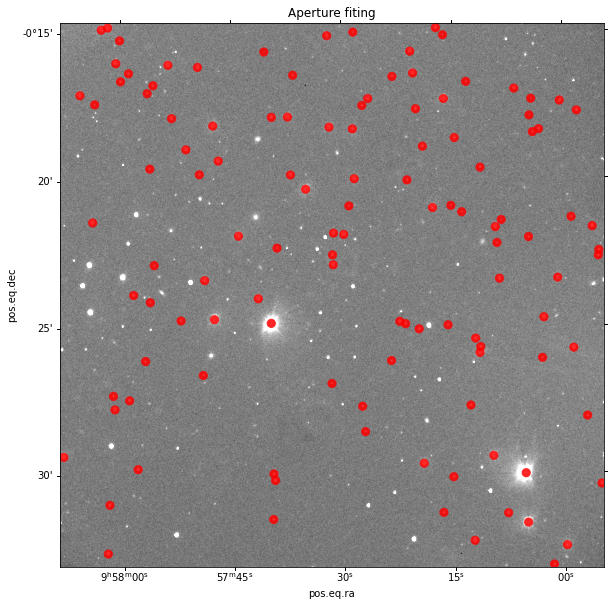

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(111,projection=WCS(header))
plt.imshow(image,cmap='gray',origin='lower',vmin=mean-4*std,vmax=mean+4*std)
#colors=['maroon','salmon','yellow','blue','cyan']
for i in range(len(apertures)):
    apertures[i].plot(color='red', alpha=0.7)
    
plt.title('Aperture fiting')
#plt.savefig('/home/abhishek/ATSOA/Photometry project/Project PPT/Aperture_fitting.png',facecolor='white',edgecolor='white')

#### Making curve of growth for isolated star

In [16]:
exposure=header['EXPOSURE'] #seconds unit
print(exposure)

150.0


In [17]:
effective_gain=exposure
error=calc_total_error(image,back,effective_gain)
phot_table=aperture_photometry(image-back,apertures,error=error)
phot_table2=aperture_photometry(image-back,an_ap)

bkg_mean=phot_table2['aperture_sum']/an_ap.area
bkg_sum=bkg_mean*an_ap.area

In [33]:
wcs=WCS(header)

In [35]:
phot_table.info

<QTable length=118>
       name         dtype  unit  class  
------------------ ------- ---- --------
                id   int64        Column
           xcenter float64  pix Quantity
           ycenter float64  pix Quantity
    aperture_sum_0 float64        Column
aperture_sum_err_0 float64        Column
    aperture_sum_1 float64        Column
aperture_sum_err_1 float64        Column
    aperture_sum_2 float64        Column
aperture_sum_err_2 float64        Column
    aperture_sum_3 float64        Column
aperture_sum_err_3 float64        Column
    aperture_sum_4 float64        Column
aperture_sum_err_4 float64        Column
    aperture_sum_5 float64        Column
aperture_sum_err_5 float64        Column
    aperture_sum_6 float64        Column
aperture_sum_err_6 float64        Column
    aperture_sum_7 float64        Column
aperture_sum_err_7 float64        Column

In [36]:
pix_x=phot_table['xcenter']
pix_y=phot_table['ycenter']

In [50]:
ra=[]
dec=[]
for i in range(len(pix_x)):
    a,b=wcs.wcs_pix2world(pix_x[i],pix_y[i],1)
    ra.append(a)
    dec.append(b)

In [59]:
phot_table['RA']=ra
phot_table['DEC']=dec

In [63]:
#phot_table.write('/home/abhishek/ATSOA/atsoa_2022/sa101_standard/Photometry_sources.csv',format='ascii')

In [19]:
ap_sum=[]
ap_size=[1,2,3,4,5,6,7,8] #unit of FWHM
row=0
col_list=['aperture_sum_0','aperture_sum_1','aperture_sum_2','aperture_sum_3',
          'aperture_sum_4','aperture_sum_5','aperture_sum_6','aperture_sum_7']

for i in col_list:
    a=phot_table[row][i]
    ap_sum.append(a)

Text(0.5, 1.0, 'Curve of growth')

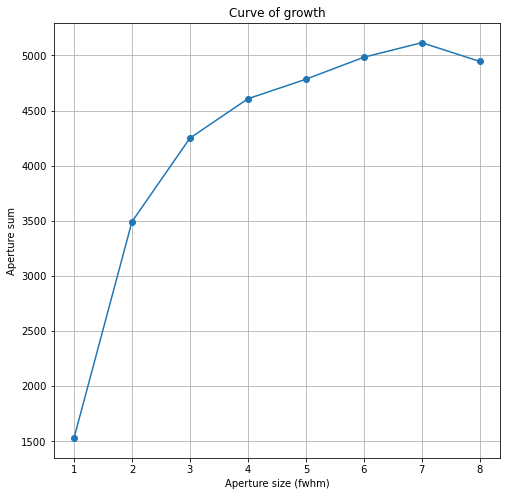

In [20]:
plt.figure(figsize=(8,8))
plt.plot(ap_size,ap_sum,'-o')
plt.grid()
plt.xlabel('Aperture size (fwhm)')
plt.ylabel('Aperture sum')
plt.title('Curve of growth')
#plt.savefig('/home/abhishek/ATSOA/Photometry project/Project PPT/Growth_curve.png',facecolor='white',edgecolor='white')